## PROJECT : PREDICTING RE-ADMISSION OF DIABETES PATIENT
Name : Nidish Murugan



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split

# Import the 8 models which will be used to predict
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier



# To Display all Columns :
pd.set_option("display.max_columns",None)

In [ ]:
# Import Dataset into Google Collab
# Mount Google Drive

drive.mount('/content/drive')
file_path_1 = '/content/drive/MyDrive/diabetes_classification_dataset (Unzipped Files)/diabetic_data.csv'
file_path_2 = '/content/drive/MyDrive/diabetes_classification_dataset (Unzipped Files)/IDS_mapping.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Converting CSV into DataFrame :

df = pd.read_csv(file_path_1)
ids_mapping = pd.read_csv(file_path_2)

In [ ]:
# Displaying IDS Mapping
ids_mapping.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [ ]:
# Display DataFrame :
df.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
# Display Dataset Shape :
df.shape

(101766, 50)

In [ ]:
# Display Data Variables :
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

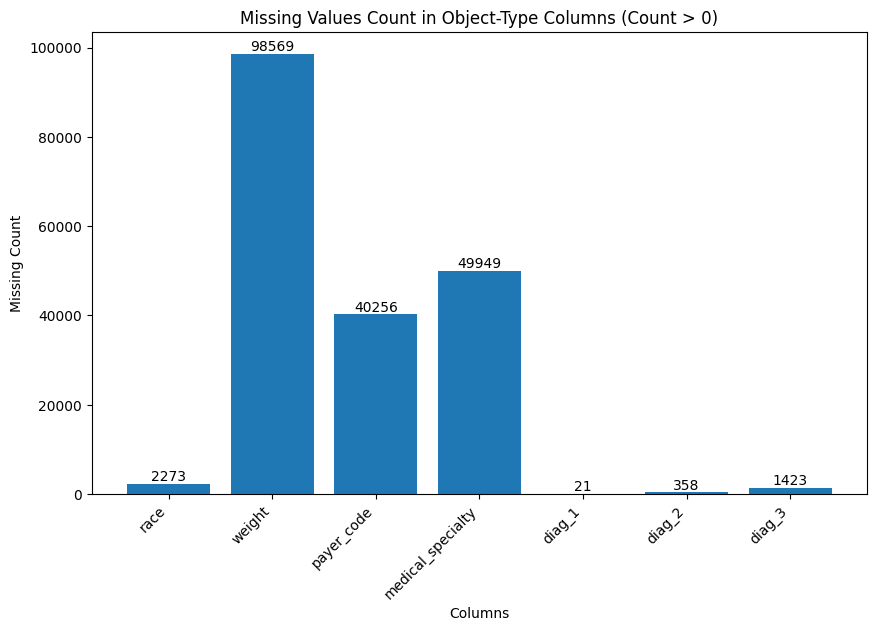

In [ ]:
# Count occurrences of '?' in each object-type column
missing_counts = []
for col in df.columns:
    if df[col].dtype == object:
        missing_count = df[col][df[col] == '?'].count()
        if missing_count > 0:
            missing_counts.append((col, missing_count))

missing_df = pd.DataFrame(missing_counts, columns=['Column', 'Missing Count'])
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(missing_df['Column'], missing_df['Missing Count'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.title('Missing Values Count in Object-Type Columns (Count > 0)')
    plt.xlabel('Columns')
    plt.ylabel('Missing Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

#Observations :
1.  More than 90% of the feature weight has missing values
2.  payer_code and Meidcal Specialty has 40 to 50% missing values.
3.  Race has considerable amount of missing values which can be handled.
4.  diag_1, diag_2 and diag_3 have less than 1% of missing values which we can decide later if want to drop or impute it.


In [ ]:
# Obeserved Data shows different missing values for Gender.
print(df['gender'].unique())

# Unknown/Invalid as missing values for Gender
print('Unknown/Invalid : ' + str(df['gender'].value_counts().get('Unknown/Invalid',0)))


['Female' 'Male' 'Unknown/Invalid']
Unknown/Invalid : 3


In [ ]:
# Dropping Payer_code, medical speciality
df = df.drop(['weight','payer_code','medical_specialty'],axis=1)

In [ ]:
# Analysing 'diag_' columns
print(df[['diag_1','diag_2','diag_3']])


        diag_1  diag_2 diag_3
0       250.83       ?      ?
1          276  250.01    255
2          648     250    V27
3            8  250.43    403
4          197     157    250
...        ...     ...    ...
101761  250.13     291    458
101762     560     276    787
101763      38     590    296
101764     996     285    998
101765     530     530    787

[101766 rows x 3 columns]


In [ ]:
# Unqiue Values in diag colums

print("Unique Values in Diag Columns \n")
print('diag_1 : ' + str(len(df['diag_1'].unique())))
print('diag_2 : ' + str(len(df['diag_2'].unique())))
print('diag_3 : ' + str(len(df['diag_3'].unique())))

Unique Values in Diag Columns 

diag_1 : 717
diag_2 : 749
diag_3 : 790


To Deal with this huge set of unique values in 'diag' columns.  rows with '?' on three columns of diag will be dropped and rest will be grouped based on the ICD9 Code provided in the Table 2 of the introductory research paper.

In [ ]:
# Finding rows  with "?" on diag_1, diag_2, diag_3
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

# Update drop_Idx with indices of specific columns with '?'
columns_to_check = ['diag_1', 'diag_2', 'diag_3', 'race']
for col in columns_to_check:
    drop_Idx.update(df[col][df[col] == '?'].index)

# Update condition_to_check based on the condition
conditions_to_check = [
    (df['discharge_disposition_id'] == 11),
    (df['gender'] == 'Unknown/Invalid')
]
for condition in conditions_to_check:
    drop_Idx.update(df[condition].index)

#Creating new dataframe eliminating the index we want to drop
new_Idx = list(set(df.index) - drop_Idx)
df = df.iloc[new_Idx]


In [ ]:
# Dropping Features 'citoglipton' and 'examide' cause they have the same values throughout the dataset.
df = df.drop(['citoglipton', 'examide'], axis = 1)

In [ ]:
#Checking for missing values in the data
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

race 0
gender 0
age 0
diag_1 0
diag_2 0
diag_3 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 0


## Feature Engineering

#AGE :
In Age feature we have a range of values. It would be better to have one single value, so we are going to take the median of the age range with the help of Python Regex

In [ ]:
from ast import Del
import regex as re
age_lst = df['age'].tolist()
n = '[10-20)'
new_age_lst = []
for n in age_lst:
  matches = re.findall(r'\d{2}',n)
  new_age_lst.append(int(sum(int(age) for age in matches)/2))

# Replacing updated age
df['age'] = new_age_lst


Creating a new_feature hospital_visits using the features inpatient admissions, emergency room visits, and outpatient visits which gives us a new important information how many times they have got admitted/visited the hospital previously.

In [ ]:
df['hospital_visit'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [ ]:
print('discharge_disposition_id unique values: ' + str(df['discharge_disposition_id'].unique()))
print('admission_source_id unique values: ' + str(df['admission_source_id'].unique()))

discharge_disposition_id unique values: [ 1  3  6  2  5  7 25 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28 19
 27]
admission_source_id unique values: [ 7  2  4  1  5 20  6  3 17  8  9 14 10 22 11 25 13]


Based on the introductory paper given in the website, we can reduce the unique values in discharge_disposition_id, admission_source_id, admission_type_id into fewer categories

In [ ]:
# Encoding admission type, discharge type, and admission source into fewer categories
df['admission_type_id'].replace({2: 1, 7: 1, 6: 5, 8: 5}, inplace=True)
df['discharge_disposition_id'].replace({6: 1, 8: 1, 9: 1, 13: 1, 3: 2, 4: 2, 5: 2, 14: 2, 22: 2, 23: 2, 24: 2, 12: 10, 15: 10, 16: 10, 17: 10, 25: 18, 26: 18}, inplace=True)
df['admission_source_id'].replace({2: 1, 3: 1, 5: 4, 6: 4, 10: 4, 22: 4, 25: 4, 15: 9, 17: 9, 20: 9, 21: 9, 13: 11, 14: 11}, inplace=True)


In [ ]:
# Encoding Gender, change, diabetesMed into binary
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

In [ ]:
# Extracting all the drugs used manually from meta data structure
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for drug in drugs:
    df[drug] = df[drug].replace('No', 0).replace('Steady', 1).replace('Up', 1).replace('Down', 1)

In [ ]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1).replace('>8', 1).replace('Norm', 0).replace('None', -99)

df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1).replace('>300', 1).replace('Norm', 0).replace('None', -99)


In [ ]:
print('Unique Patient identification Number Count : ' + str(len(list(df['patient_nbr'].unique()))))

# Unique patient identification number is lesser than the total dataset count.
# Inorder to remove the bias we are going to remove the duplicates from the dataset.

df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df.shape

Unique Patient identification Number Count : 67580


(67580, 46)

In [ ]:
df['readmitted'].value_counts()

NO     39826
>30    21625
<30     6129
Name: readmitted, dtype: int64

In [ ]:
# As per our problem statement we are trying to find the number of patients who got redadmitted.
# hence converting '>30' and '<30' into '1' and 'NO' into '0'

df['readmitted'] = df['readmitted'].replace('>30', 1).replace('<30', 1)

df['readmitted'] = df['readmitted'].replace('NO', 0)

From Table 2 in the introductory paper, it clearly groups different ICD numbers into groups which we will take advantage of.  It will reduce the number of unique values and make it into 9 unique groups.

In [ ]:
# Creating additional columns for diagnosis
df['level1_diag1'] = df['diag_1']
df['level2_diag1'] = df['diag_1']
df['level1_diag2'] = df['diag_2']
df['level2_diag2'] = df['diag_2']
df['level1_diag3'] = df['diag_3']
df['level2_diag3'] = df['diag_3']

In [ ]:
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_2'].str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_2'].str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_3'].str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
df.loc[df['diag_3'].str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
df['level2_diag1'] = df['level2_diag1'].replace('?', -1)
df['level1_diag2'] = df['level1_diag2'].replace('?', -1)
df['level2_diag2'] = df['level2_diag2'].replace('?', -1)
df['level1_diag3'] = df['level1_diag3'].replace('?', -1)
df['level2_diag3'] = df['level2_diag3'].replace('?', -1)

In [ ]:
df['level1_diag1'] = df['level1_diag1'].astype(float)
df['level2_diag1'] = df['level2_diag1'].astype(float)
df['level1_diag2'] = df['level1_diag2'].astype(float)
df['level2_diag2'] = df['level2_diag2'].astype(float)
df['level1_diag3'] = df['level1_diag3'].astype(float)
df['level2_diag3'] = df['level2_diag3'].astype(float)

In [ ]:
def map_diag_category(value):
    if (value >= 390 and value < 460) or (np.floor(value) == 785):
        return 1
    elif (value >= 460 and value < 520) or (np.floor(value) == 786):
        return 2
    elif (value >= 520 and value < 580) or (np.floor(value) == 787):
        return 3
    elif (np.floor(value) == 250):
        return 4
    elif (value >= 800 and value < 1000):
        return 5
    elif (value >= 710 and value < 740):
        return 6
    elif (value >= 580 and value < 630) or (np.floor(value) == 788):
        return 7
    elif (value >= 140 and value < 240):
        return 8
    else:
        return 0

df['level1_diag1'] = df['level1_diag1'].apply(map_diag_category)
df['level1_diag2'] = df['level1_diag2'].apply(map_diag_category)
df['level1_diag3'] = df['level1_diag3'].apply(map_diag_category)


In [ ]:
def map_diag_category(value):
    if (value >= 390 and value < 399):
        return 1
    elif (value >= 401 and value < 415):
        return 2
    elif (value >= 415 and value < 460):
        return 3
    elif (np.floor(value) == 785):
        return 4
    elif (value >= 460 and value < 489):
        return 5
    elif (value >= 490 and value < 497):
        return 6
    elif (value >= 500 and value < 520):
        return 7
    elif (np.floor(value) == 786):
        return 8
    elif (value >= 520 and value < 530):
        return 9
    elif (value >= 530 and value < 544):
        return 10
    elif (value >= 550 and value < 554):
        return 11
    elif (value >= 555 and value < 580):
        return 12
    elif (np.floor(value) == 787):
        return 13
    elif (np.floor(value) == 250):
        return 14
    elif (value >= 800 and value < 1000):
        return 15
    elif (value >= 710 and value < 740):
        return 16
    elif (value >= 580 and value < 630):
        return 17
    elif (np.floor(value) == 788):
        return 18
    elif (value >= 140 and value < 240):
        return 19
    elif value >= 240 and value < 280 and (np.floor(value) != 250):
        return 20
    elif (value >= 680 and value < 710) or (np.floor(value) == 782):
        return 21
    elif (value >= 290 and value < 320):
        return 22
    else:
        return 0

df['level2_diag1'] = df['level2_diag1'].apply(map_diag_category)
df['level2_diag2'] = df['level2_diag2'].apply(map_diag_category)
df['level2_diag3'] = df['level2_diag3'].apply(map_diag_category)


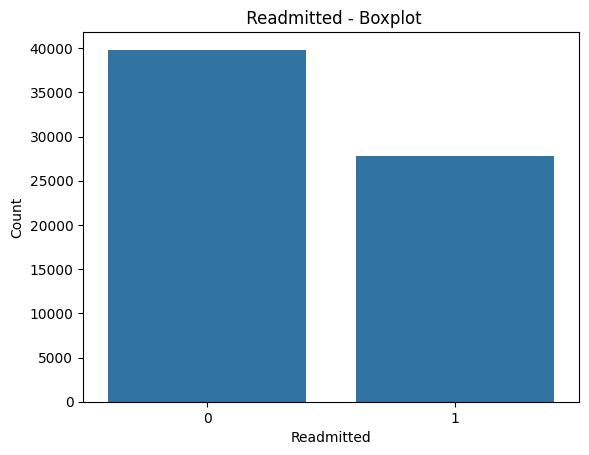

In [ ]:
sns.countplot(x='readmitted', data=df)
plt.title(' Readmitted - Boxplot')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()

In [ ]:
# Dropping Diag_1,_2,_3
df = df.drop(['diag_1','diag_2','diag_3'],axis=1)

#one-hot encoding 'race':
df = pd.get_dummies(df)


In [ ]:
df.dtypes

encounter_id                int64
patient_nbr                 int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
acetohexamide               int64
glipizide                   int64
glyburide                   int64
tolbutamide                 int64
pioglitazone                int64
rosiglitazone               int64
acarbose                    int64
miglitol      

## MODELING

Assigning Train, Validation and Test Split for the Dataset

In [ ]:
# Splitting Features and Expected Output
y = df['readmitted']
del df['readmitted']
X = df

In [ ]:
print(X.shape)
print(y.shape)

(67580, 52)
(67580,)


In [ ]:
# Splitting Dataset into Train, Test and Validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Dataset size of Train, Test and Validation
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Validation set:", X_val.shape, y_val.shape)

Train set: (47306, 52) (47306,)
Test set: (10137, 52) (10137,)
Validation set: (10137, 52) (10137,)


##MODEL 1 : LOGISTIC REGRESSION

In [ ]:
#Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Predictions on the train set
y_train_pred = logreg.predict(X_train)
train_accuracy_logisitic = accuracy_score(y_train, y_train_pred)
train_f1_logisitic = f1_score(y_train, y_train_pred)

print("Train Accuracy:", train_accuracy_logisitic)
print("Train F1-score:", train_f1_logisitic)

# Predictions on the test set
y_test_logistic = logreg.predict(X_test)
test_accuracy_logistic = accuracy_score(y_test, y_test_logistic)
test_f1_logisitic = f1_score(y_test, y_test_logistic)
y_prob_logistic = logreg.predict_proba(X_test)


print("Test Accuracy:", test_accuracy_logistic)
print("Test F1-score:", test_f1_logisitic)

# Predictions on the validation set
y_val_pred = logreg.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Validation F1-score:", val_f1)


Train Accuracy: 0.6083160698431489
Train F1-score: 0.3337528316133904
Test Accuracy: 0.6083653941008188
Test F1-score: 0.3387741505662891
Validation Accuracy: 0.615172141659268
Validation F1-score: 0.34820384294068507


##MODEL 2 : DECISION TREE

In [ ]:
# Decision Tree Classifier
dtree = DecisionTreeClassifier(max_depth=28, criterion="entropy", min_samples_split=10, random_state=42)
dtree.fit(X_train, y_train)

# Predictions on the train set
y_train_pred = dtree.predict(X_train)
train_accuracy_dt = accuracy_score(y_train, y_train_pred)
train_f1_dt = f1_score(y_train, y_train_pred)

print("Train Accuracy:", train_accuracy_dt)
print("Train F1-score:", train_f1_dt)

# Predictions on the test set
y_test_dt = dtree.predict(X_test)
test_accuracy_dt = accuracy_score(y_test, y_test_dt)
test_f1_dt = f1_score(y_test, y_test_dt)
y_prob_dt = dtree.predict_proba(X_test)


print("Test Accuracy:", test_accuracy_dt)
print("Test F1-score:", test_f1_dt)

# Predictions on the validation set
y_val_pred = dtree.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Validation F1-score:", val_f1)


Train Accuracy: 0.9136895954001607
Train F1-score: 0.8927248364467566
Test Accuracy: 0.574726250369932
Test F1-score: 0.4784029038112523
Validation Accuracy: 0.5776857058301272
Validation F1-score: 0.472588394727116


##MODEL 3 : RIDGE REGRESSION

In [ ]:
# RidgeClassifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train, y_train)

# Make predictions on different sets
y_train_pred = ridge_classifier.predict(X_train)
y_test_rr = ridge_classifier.predict(X_test)
y_val_pred = ridge_classifier.predict(X_val)

# Evaluate performance
train_accuracy_rr = accuracy_score(y_train, y_train_pred)
test_accuracy_rr = accuracy_score(y_test, y_test_rr)
val_accuracy_rr = accuracy_score(y_val, y_val_pred)

train_f1_rr = f1_score(y_train, y_train_pred)
test_f1_rr = f1_score(y_test, y_test_rr)
val_f1_rr = f1_score(y_val, y_val_pred)

# Print the scores
print("Training Accuracy:", train_accuracy_rr)
print("Testing Accuracy:", test_accuracy_rr)
print("Validation Accuracy:", val_accuracy_rr)

print("\nTraining F1 Score:", train_f1_rr)
print("Testing F1 Score:", test_f1_rr)
print("Validation F1 Score:", val_f1_rr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.75184e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training Accuracy: 0.635521921109373
Testing Accuracy: 0.6352964387885962
Validation Accuracy: 0.6356910328499557

Training F1 Score: 0.41996905066271956
Testing F1 Score: 0.41971433056035157
Validation F1 Score: 0.4164954969189446


##MODEL 4 : KNN CLASSIFIER

In [ ]:
# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_knn = knn_classifier.predict(X_train)

accuracy_train_knn = accuracy_score(y_train, y_train_knn)
print(f'Training Accuracy: {accuracy_train_knn:.2f}')
f1_train_knn = f1_score(y_train, y_train_knn)
print(f'Training F1-score: {f1_train_knn:.2f}')

# Predictions on the validation set
y_val_pred = knn_classifier.predict(X_val)
accuracy_val_knn = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy_val_knn:.2f}')
f1_val_knn = f1_score(y_val, y_val_pred)
print(f'Validation F1-score: {f1_val_knn:.2f}')

# Predictions on the test set
y_test_knn = knn_classifier.predict(X_test)

accuracy_test_knn = accuracy_score(y_test, y_test_knn)
print(f'Test Accuracy: {accuracy_test_knn:.2f}')

f1_test_knn = f1_score(y_test, y_test_knn)
print(f'Test F1-score: {f1_test_knn:.2f}')

Training Accuracy: 0.72
Training F1-score: 0.64
Validation Accuracy: 0.59
Validation F1-score: 0.47
Test Accuracy: 0.59
Test F1-score: 0.46


##MODEL 5: GAUSSIAN NAIVE BAYES

In [ ]:
# Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_nb = nb_classifier.predict(X_train)
accuracy_train_nb = accuracy_score(y_train, y_train_nb)
print(f'Training Accuracy: {accuracy_train_nb:.2f}')


f1_train_nb = f1_score(y_train, y_train_nb)
print(f'Training F1-score: {f1_train_nb:.2f}')

# Predictions on the validation set
y_val_pred = nb_classifier.predict(X_val)

accuracy_val_nb = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy_val_nb:.2f}')

f1_val_nb = f1_score(y_val, y_val_pred)
print(f'Validation F1-score: {f1_val_nb:.2f}')

# Predictions on the test set
y_test_nb = nb_classifier.predict(X_test)
y_prob_nb = nb_classifier.predict_proba(X_test)

accuracy_test_nb = accuracy_score(y_test, y_test_nb)
print(f'Test Accuracy: {accuracy_test_nb:.2f}')

f1_test_nb = f1_score(y_test, y_test_nb)
print(f'Test F1-score: {f1_test_nb:.2f}')


Training Accuracy: 0.60
Training F1-score: 0.17
Validation Accuracy: 0.61
Validation F1-score: 0.19
Test Accuracy: 0.60
Test F1-score: 0.18


##MODEL 6 : RANDOM FOREST

In [ ]:
# RandomForest Classifier
rm = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", min_samples_split=10, random_state=42)
rm.fit(X_train, y_train)

# Predictions on the train set
y_train_rf = rm.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_train_rf)
train_f1_rf = f1_score(y_train, y_train_rf)


print("Train Accuracy:", train_accuracy_rf)
print("Train F1-score:", train_f1_rf)

# Predictions on the test set
y_test_rf = rm.predict(X_test)
y_prob_rf = rm.predict_proba(X_test)

test_accuracy_rf = accuracy_score(y_test, y_test_rf)
test_f1_rf = f1_score(y_test, y_test_rf)


print("Test Accuracy:", test_accuracy_rf)
print("Test F1-score:", test_f1_rf)

# Predictions on the validation set
y_val_pred = rm.predict(X_val)
val_accuracy_rf = accuracy_score(y_val, y_val_pred)
val_f1_rf = f1_score(y_val, y_val_pred)


print("Validation Accuracy:", val_accuracy_rf)
print("Validation F1-score:", val_f1_rf)

Train Accuracy: 0.9033103623219042
Train F1-score: 0.8755577320709543
Test Accuracy: 0.6234586169478149
Test F1-score: 0.4868933996504906
Validation Accuracy: 0.6219788892177173
Validation F1-score: 0.4783555676558671


##MODEL 7 : XG-BOOST

In [ ]:
# XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions on the training set
y_train_xg = xgb_model.predict(X_train)

accuracy_train_xg = accuracy_score(y_train, y_train_xg)
print(f"Training Accuracy: {accuracy_train_xg:.2f}")

f1_train_xg = f1_score(y_train, y_train_xg)
print(f"Training F1 Score: {f1_train_xg:.2f}")

# Predictions on the validation set
y_val_pred = xgb_model.predict(X_val)

accuracy_val_xg = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy_val_xg:.2f}")

f1_val_xg = f1_score(y_val, y_val_pred)
print(f"Validation F1 Score: {f1_val_xg:.2f}")

# Predictions on the test set
y_test_xg = xgb_model.predict(X_test)
y_prob_xg = xgb_model.predict_proba(X_test)

accuracy_test_xg = accuracy_score(y_test, y_test_xg)
print(f"Test Accuracy: {accuracy_test_xg:.2f}")

f1_test_xg = f1_score(y_test, y_test_xg)
print(f"Test F1 Score: {f1_test_xg:.2f}")


Training Accuracy: 0.76
Training F1 Score: 0.68
Validation Accuracy: 0.65
Validation F1 Score: 0.52
Test Accuracy: 0.66
Test F1 Score: 0.54


## MODEL 8 : BAGGING CLASSIFIER

In [ ]:
#  Base classifier (Random Forest)
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# BaggingClassifier
bagging_model = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)

# Predictions on the training set
y_train_bc = bagging_model.predict(X_train)

accuracy_train_bc = accuracy_score(y_train, y_train_bc)
print(f"Training Accuracy: {accuracy_train_bc}")
f1_train_bc = f1_score(y_train, y_train_bc)
print(f"Training F1 Score: {f1_train_bc}")

# Predictions on the validation set
y_val_pred = bagging_model.predict(X_val)
accuracy_val_bc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy_val_bc}")

f1_val_bc = f1_score(y_val, y_val_pred)
print(f"Validation F1 Score: {f1_val_bc}")

# Predictions on the test set
y_test_bc = bagging_model.predict(X_test)
y_prob_bc = bagging_model.predict_proba(X_test)
accuracy_test_bc = accuracy_score(y_test, y_test_bc)
print(f"Test Accuracy: {accuracy_test_bc}")
f1_test_bc = f1_score(y_test, y_test_bc)
print(f"Test F1 Score: {f1_test_bc}")


Training Accuracy: 0.9830042700714497
Training F1 Score: 0.9789814911638608
Validation Accuracy: 0.6569004636480221
Validation F1 Score: 0.4922627737226277
Test Accuracy: 0.6549274933412252
Test F1 Score: 0.49097788125727587


# Model Selection

In [ ]:
# Train and Test Accuracy scores for 8 models
models = ['Logistic Regression', 'Decision Tree', 'Ridge Regression', 'KNN', 'Gaussian Naive Bayes','Random Forest','XG-Boost','Bagging Classifier']

test_accuracy_scores = [test_accuracy_logistic, test_accuracy_dt, test_accuracy_rr, accuracy_test_knn, accuracy_test_nb, test_accuracy_rf, accuracy_test_xg, accuracy_test_bc]
train_accuracy_scores = [train_accuracy_logisitic, train_accuracy_dt, train_accuracy_rr, accuracy_train_knn, accuracy_train_nb, train_accuracy_rf, accuracy_train_xg, accuracy_train_bc]


In [ ]:
# Train and Test F1-scores for 8 models

test_f1_scores = [test_f1_logisitic, test_f1_dt, test_f1_rr, f1_test_knn, f1_test_nb, test_f1_rf, f1_test_xg, f1_test_bc]
train_f1_scores = [train_f1_logisitic, train_f1_dt, train_f1_rr, f1_train_knn, f1_train_nb, train_f1_rf, f1_train_xg, f1_train_bc]

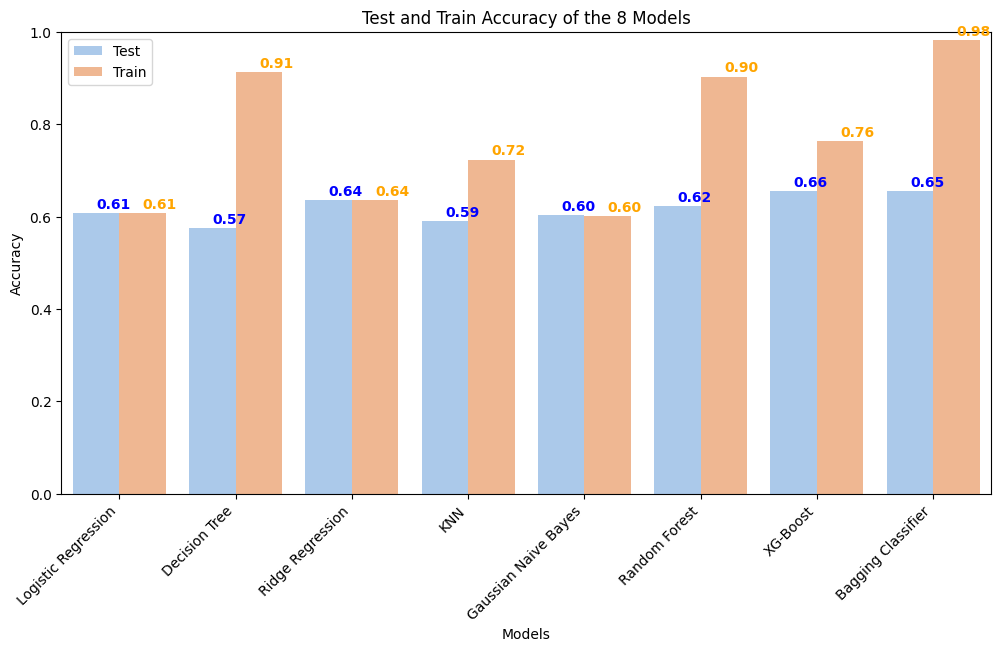

In [ ]:
data = {'Model': models * 2, 'Accuracy': test_accuracy_scores + train_accuracy_scores, 'Type': ['Test'] * len(models) + ['Train'] * len(models)}
dummy_df = pd.DataFrame(data)

# Test and Train accuracy bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Type', data=dummy_df, palette='pastel')
for i, v in enumerate(test_accuracy_scores):
    plt.text(i - 0.2, v + 0.01, f'{v:.2f}', color='blue', fontweight='bold')

for i, v in enumerate(train_accuracy_scores):
    plt.text(i + 0.2, v + 0.01, f'{v:.2f}', color='orange', fontweight='bold')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test and Train Accuracy of the 8 Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.show()


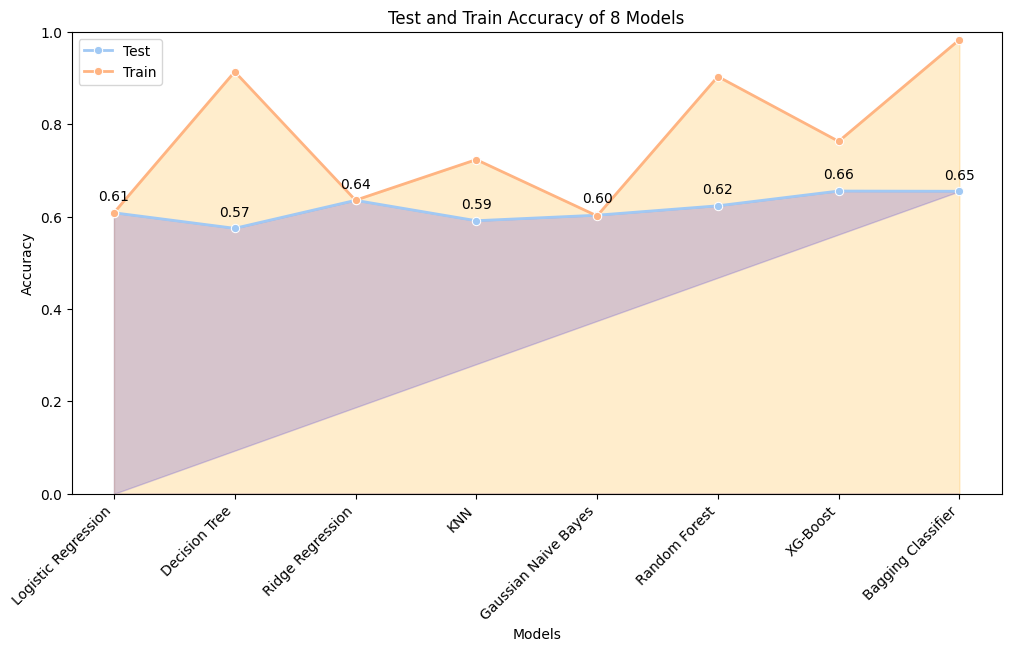

In [ ]:
data = {'Model': models * 2, 'Accuracy': test_accuracy_scores + train_accuracy_scores, 'Type': ['Test'] * len(models) + ['Train'] * len(models)}
dummy_df = pd.DataFrame(data)

# Area graph for Test and Train Accuracy of 8 Models
plt.figure(figsize=(12, 6))
sns.lineplot(x='Model', y='Accuracy', hue='Type', marker='o', data=dummy_df, palette='pastel', sort=False, linewidth=2)
for i, row in dummy_df.iterrows():
    plt.annotate(f'{row["Accuracy"]:.2f}', (i, row["Accuracy"] + 0.02), ha='center', va='bottom')

plt.fill_between(dummy_df['Model'], 0, dummy_df['Accuracy'], where=(dummy_df['Type'] == 'Test'), interpolate=True, color='blue', alpha=0.2)
plt.fill_between(dummy_df['Model'], 0, dummy_df['Accuracy'], where=(dummy_df['Type'] == 'Train'), interpolate=True, color='orange', alpha=0.2)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test and Train Accuracy of 8 Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.show()


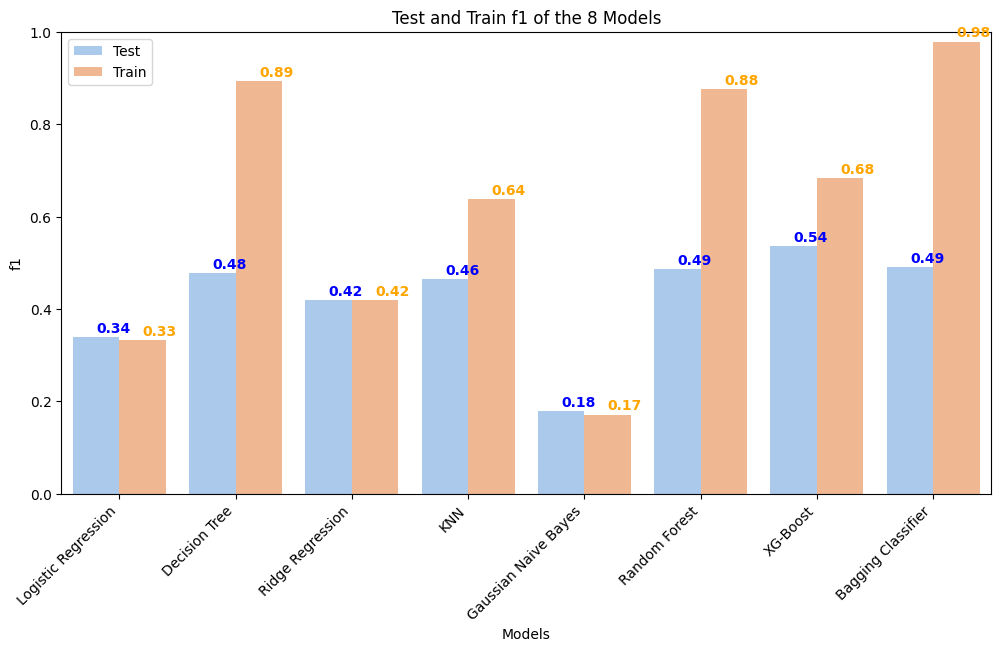

In [ ]:
data = {'Model': models * 2, 'f1': test_f1_scores + train_f1_scores, 'Type': ['Test'] * len(models) + ['Train'] * len(models)}
dummy_df = pd.DataFrame(data)

# Plotting the grouped bar chart with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='f1', hue='Type', data=dummy_df, palette='pastel')

for i, v in enumerate(test_f1_scores):
    plt.text(i - 0.2, v + 0.01, f'{v:.2f}', color='blue', fontweight='bold')
for i, v in enumerate(train_f1_scores):
    plt.text(i + 0.2, v + 0.01, f'{v:.2f}', color='orange', fontweight='bold')

plt.xlabel('Models')
plt.ylabel('f1')
plt.title('Test and Train f1 of the 8 Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.show()


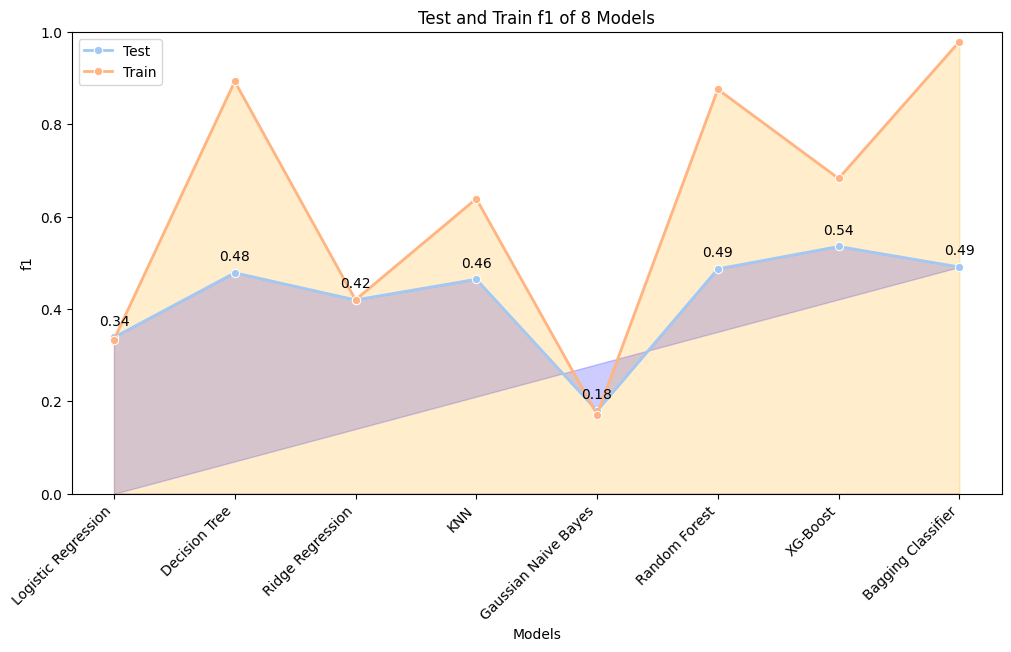

In [ ]:
data = {'Model': models * 2, 'f1': test_f1_scores + train_f1_scores, 'Type': ['Test'] * len(models) + ['Train'] * len(models)}
dummy_df = pd.DataFrame(data)

# Area graph for Test and Train f1 of 8 Models
plt.figure(figsize=(12, 6))
sns.lineplot(x='Model', y='f1', hue='Type', marker='o', data=dummy_df, palette='pastel', sort=False, linewidth=2)

for i, row in dummy_df.iterrows():
    plt.annotate(f'{row["f1"]:.2f}', (i, row["f1"] + 0.02), ha='center', va='bottom')

plt.fill_between(dummy_df['Model'], 0, dummy_df['f1'], where=(dummy_df['Type'] == 'Test'), interpolate=True, color='blue', alpha=0.2)
plt.fill_between(dummy_df['Model'], 0, dummy_df['f1'], where=(dummy_df['Type'] == 'Train'), interpolate=True, color='orange', alpha=0.2)

plt.xlabel('Models')
plt.ylabel('f1')
plt.title('Test and Train f1 of 8 Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [ ]:
# Tabular dataframe of the results of the 8 models
data = {
    'Model': models,
    'Test Accuracy': test_accuracy_scores,
    'Train Accuracy': train_accuracy_scores,
    'Test F1 Score': test_f1_scores,
    'Train F1 Score': train_f1_scores
}

df_results = pd.DataFrame(data)
print(df_results)


                  Model  Test Accuracy  Train Accuracy  Test F1 Score  \
0   Logistic Regression       0.608365        0.608316       0.338774   
1         Decision Tree       0.574726        0.913690       0.478403   
2      Ridge Regression       0.635296        0.635522       0.419714   
3                   KNN       0.591201        0.723439       0.464461   
4  Gaussian Naive Bayes       0.603137        0.601594       0.179817   
5         Random Forest       0.623459        0.903310       0.486893   
6              XG-Boost       0.655421        0.762948       0.535444   
7    Bagging Classifier       0.654927        0.983004       0.490978   

   Train F1 Score  
0        0.333753  
1        0.892725  
2        0.419969  
3        0.638781  
4        0.171670  
5        0.875558  
6        0.682611  
7        0.978981  


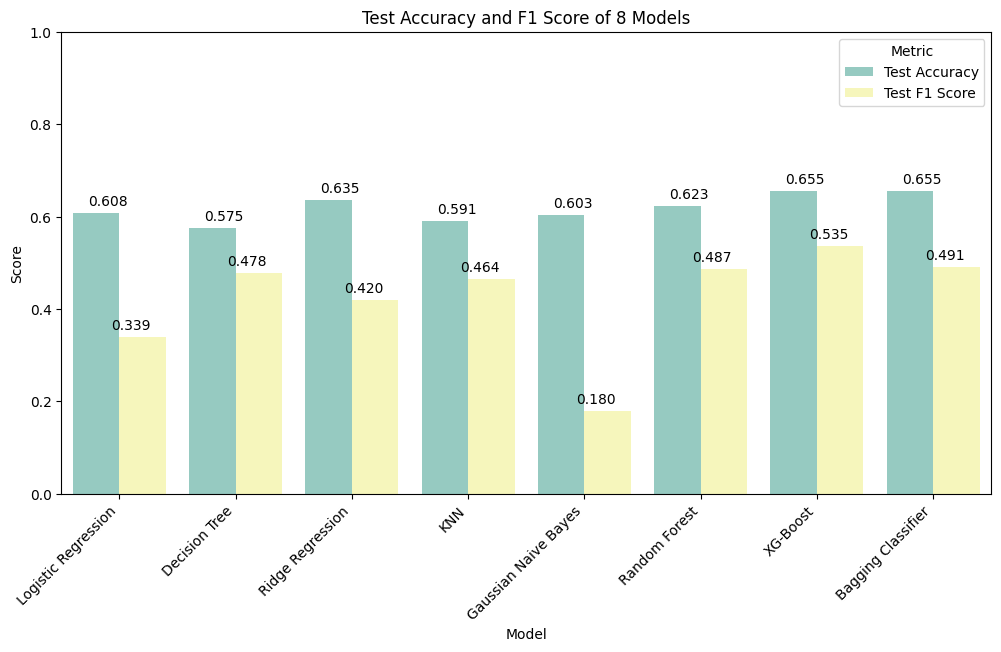

In [ ]:
data = {
    'Model': models * 2,
    'Metric': ['Test Accuracy'] * len(models) + ['Test F1 Score'] * len(models),
    'Score': test_accuracy_scores + test_f1_scores
}

df_results = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_results, palette='Set3')
plt.title('Test Accuracy and F1 Score of 8 Models')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for i, model in enumerate(models):
    for j, metric in enumerate(['Test Accuracy', 'Test F1 Score']):
        value = df_results[(df_results['Model'] == model) & (df_results['Metric'] == metric)]['Score'].iloc[0]
        ax.text(i + j * 0.2 - 0.1, value + 0.01, f'{value:.3f}', ha='center', va='bottom', color='black')

plt.show()


#Conclusion
Based on the comprehensive analysis conducted, XG-Boost emerges as the optimal choice, showcasing superior performance in both test accuracy and F1-Score. This harmonious balance between accuracy and F1-Score positions XG-Boost as the preferred model for the current dataset and establishes it as a robust choice for future datasets within similar contexts.